In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
pregion = 'southern'
inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+pregion+'_cross_15UTC_1985-2018_peru.nc'

In [4]:
dry_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/dry_spells_1mm_3-7days_StartOfSpell.nc')
wet_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_spells_1mm_3-7days_StartOfSpell.nc')
dry_test.name = 'dry'
wet_test.name = 'wet'

In [5]:
ds = xr.open_dataset(inpath)

In [6]:
ds

<xarray.Dataset>
Dimensions:    (level: 17, longitude: 101, time: 6092)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 1986-03-23 1986-11-18 ... 2017-10-08
Data variables:
    d          (time, level, longitude) float32 ...
    z          (time, level, longitude) float32 ...
    r          (time, level, longitude) float32 ...
    q          (time, level, longitude) float32 ...
    t          (time, level, longitude) float32 ...
    u          (time, level, longitude) float32 ...
    v          (time, level, longitude) float32 ...
    w          (time, level, longitude) float32 ...

In [7]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000

In [8]:
region = pregion
spell_length = 3
alls = regions[region]

In [9]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [10]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')
hei = height['h'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()

In [11]:
height

<xarray.Dataset>
Dimensions:    (latitude: 77, longitude: 101)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.5 0.75 1.0
Data variables:
    h          (latitude, longitude) float64 ...

In [12]:
topo = topo_full['z'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()

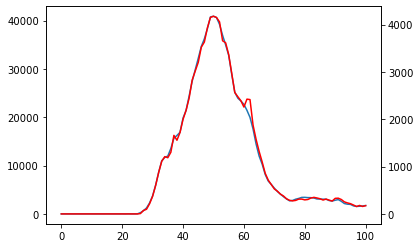

In [13]:
f = plt.figure()
ax = f.add_subplot(111)
ax1 = ax.twinx()
ax.plot(topo)
ax1.plot(hei, color='red')

In [14]:
dummy = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc')[0]).isel(time=0, level=0)
dummy = uda.flip_lat(dummy)

In [15]:
dry = dummy.salem.transform(dry_test, interp='nearest').where(height>=2000)
wet = dummy.salem.transform(wet_test, interp='nearest').where(height>=2000)

In [16]:
ds_filtered = ds.where(ds['z']>topo)

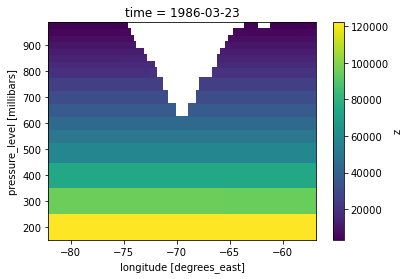

In [17]:
ds_filtered['z'].isel(time=0).plot()

In [18]:
def get_spells(spell_ds,alls,spell_length,era_times, equal=None, gt=None):
    
    mask = 0
    if gt is not None:
        mask = spell_ds >= spell_length
    if equal is not None:
        mask = spell_ds == spell_length
    
    #ipdb.set_trace()
    dry_region = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(mask).count('latitude').squeeze()
    dry_region_all = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(np.isfinite(spell_ds)).count('latitude').squeeze()
    #ipdb.set_trace()
    dry_dates = dry_region.where((dry_region.mean(['longitude'])/dry_region_all.mean(['longitude'])>0.15), drop=True)  # fraction covered by spell, 0.25 means 25% of pixels on day
    
    drydates = []
    for edates in era_times:
        dpos = np.where(edates.values == dry_dates.time.values)
        #ipdb.set_trace()
        if np.sum(dpos)>0:
            #ipdb.set_trace()
            drydates.append(pd.Timestamp(dry_dates.time.values[dpos][0]))
    return pd.to_datetime(drydates)

In [19]:
drydates = get_spells(dry,alls,3,ds_filtered.time, equal=True)

In [20]:
wetdates = get_spells(wet,alls,3,ds_filtered.time, equal=True)

In [21]:
drydates7 = get_spells(dry,alls,5,ds_filtered.time, gt=True)

In [22]:
wetdates7 = get_spells(wet,alls,5,ds_filtered.time, gt=True)

In [23]:
def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.8, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    ax.set_ylim(170,1000)
    #ax.set_xlim(-81.5,-60)
    # Adjust the y-axis to be logarithmic
    #ax.set_yscale('symlog')
    #ax.set_yticklabels(np.arange(1000, 50, -100))
    
    #ax.set_yticks(np.arange(1000, 50, -100))
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002, headwidth=7)
#         qk = plt.quiverkey(qu, 0.45, 0.52, 1, '1 m s$^{-1}$ | ',
#                            labelpos='E', coordinates='figure')
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=1.7, linestyles='solid' )
        plt.clabel(cs, inline=1, fontsize=8, fmt='%1.1f')  #, fmt='%1.1f'
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%1.1f')  # adds colorbar '%d'
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp

In [24]:
dds = drydates# -pd.Timedelta('1days')
wds = wetdates #-pd.Timedelta('1days')
dds7 = drydates7 #-pd.Timedelta('1days')
wds7 = wetdates7 #-pd.Timedelta('1days')

slices_dry = ds_filtered.sel(time=dds).mean('time')
slices_wet = ds_filtered.sel(time=wds).mean('time')
sli_dry = ds_filtered.sel(time=dds)#.mean('time')
sli_wet = ds_filtered.sel(time=wds)#.mean('time')

In [25]:
slices_all_dryclim = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
slices_all_wetclim = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
slices_all_dryclim7 = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds7.dayofyear)).mean('dayofyear')
slices_all_wetclim7 = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds7.dayofyear)).mean('dayofyear')

slices_all = ds_filtered.mean('time')
sli_all = ds_filtered

In [26]:
slices_dry

<xarray.Dataset>
Dimensions:    (level: 17, longitude: 101)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
Data variables:
    d          (level, longitude) float32 -7.775284e-07 ... 2.4012365e-07
    z          (level, longitude) float32 121653.38 121659.71 ... 3126.5308
    r          (level, longitude) float32 50.434727 50.91093 ... 71.60039
    q          (level, longitude) float32 3.7057012e-05 ... 0.01635448
    t          (level, longitude) float32 219.14394 219.15771 ... 300.02887
    u          (level, longitude) float32 7.475368 7.332979 ... 0.55589837
    v          (level, longitude) float32 -9.018893 -9.025918 ... -1.1371195
    w          (level, longitude) float32 0.012363569 ... -0.017421192

In [27]:
slices_dry7 = ds_filtered.sel(time=dds7).mean('time')
slices_wet7 = ds_filtered.sel(time=wds7).mean('time')
sli_dry7 = ds_filtered.sel(time=dds7)#.mean('time')
sli_wet7 = ds_filtered.sel(time=wds7)#.mean('time')

In [28]:
slices_months = [('3 dry',slices_dry, sli_dry, slices_all_dryclim), ('3 wet',slices_wet, sli_wet, slices_all_wetclim), ('>5 dry', slices_dry7, sli_dry7, slices_all_dryclim7), ('>5 wet', slices_wet7, sli_wet7, slices_all_wetclim7)]

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: The following kwargs were not used by contour: 'linewidth'


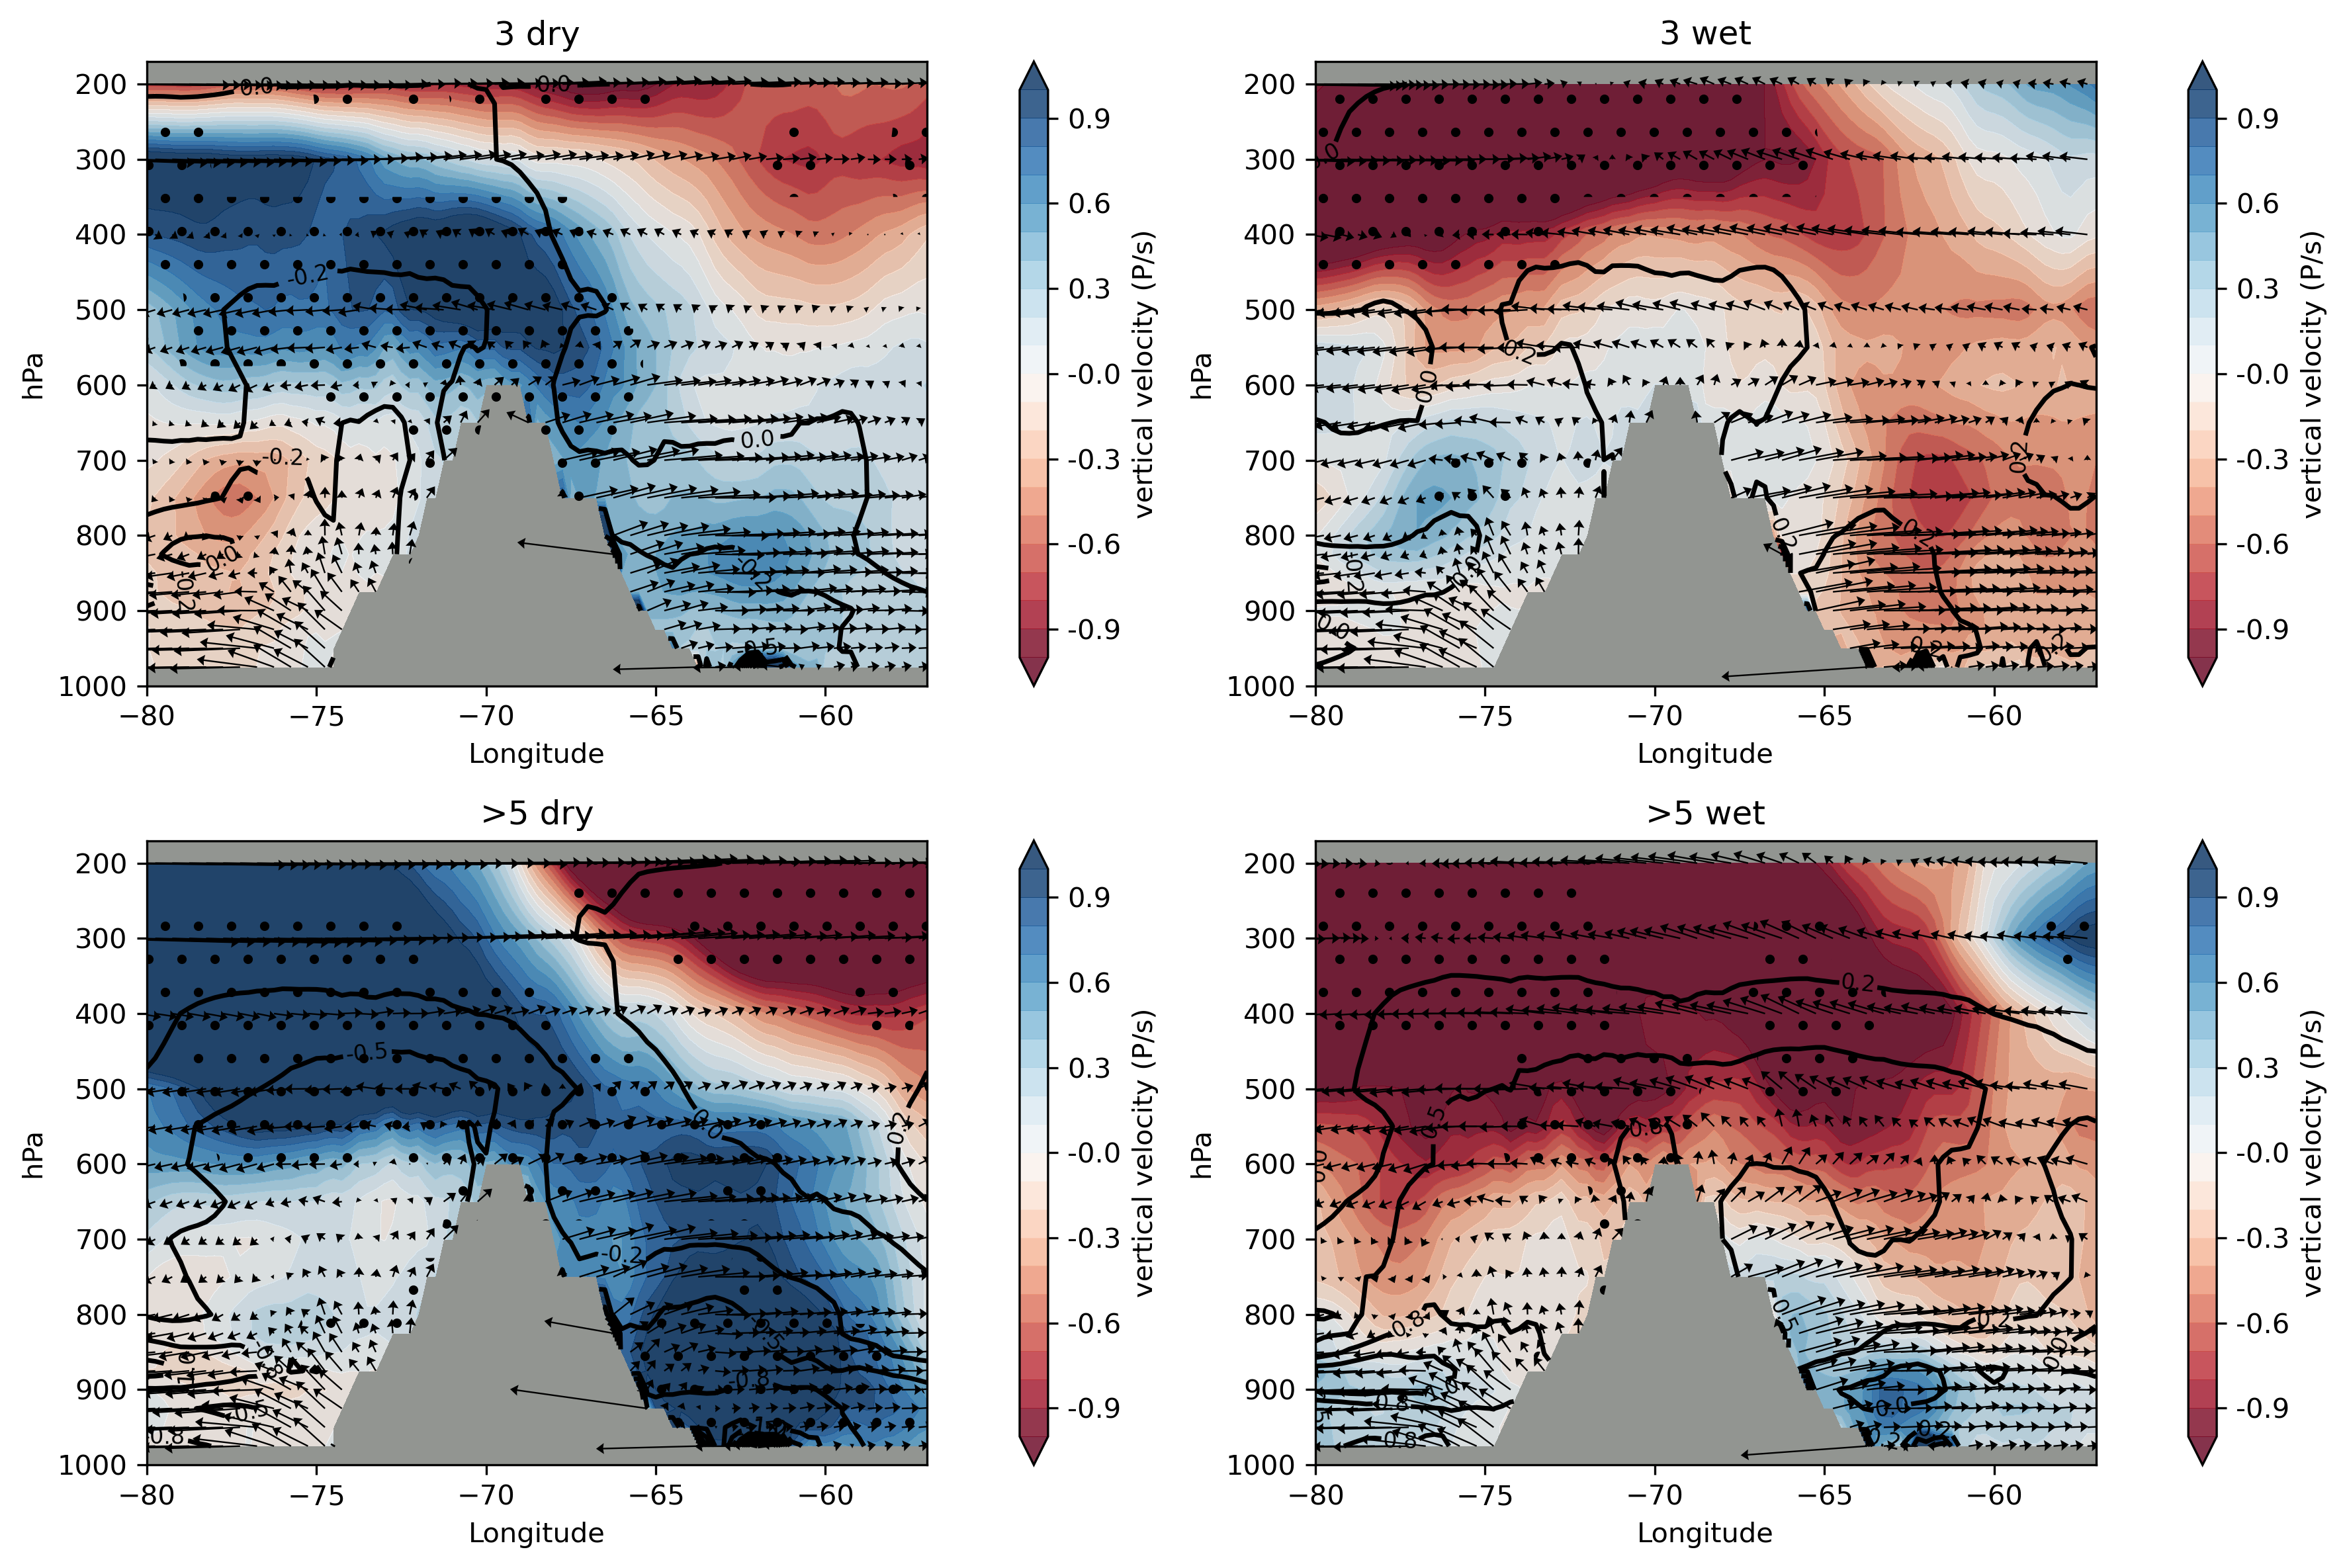

In [145]:
f = plt.figure(figsize=(12,8), dpi=300)

for ids, tt in enumerate([11,12,1,3,]):
    
    slices = slices_months[ids][1]
    tag = slices_months[ids][0]
    sli = slices#.isel(month=())
    slices_ttest = slices_months[ids][2]
    slice_clim = slices_months[ids][3]

#     p = units.Quantity(sli.level.values, 'hPa')

#     t = units.Quantity(sli['t'].values, 'K')
#     q = units.Quantity(sli['q'].values, 'kg/kg')


#     dewp = calc.dewpoint_from_specific_humidity(q.T, t.T, p).T
#     theta_e = calc.equivalent_potential_temperature(p,t.T,dewp.T).T
#     theta = calc.potential_temperature(p,t.T).T

    # "current zonal wind" wind vectors
    vano = sli['u']
    wano = sli['w']*(-5)  # multiplied by 10 since vertical component is very small compared to horizontal one
    vclim = slices_all['u']
    wclim = slices_all['w']*(-5)
    st=2
    sarrow = 1
    xquiv = sli.longitude[sarrow::st]
    yquiv = sli.level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]
    uuc = (vclim)[::, sarrow::st]  
    wwc = (wclim)[::, sarrow::st]  

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 40}

    # temperature and moisture check
    #data = (np.array(theta.data).T-np.nanmean(theta.data, axis=1)).T
    var = 'v'
    a = slices_ttest[var] #* slices_ttest['q']
    b = sli_all[var] #* sli_all['q']
    tstat, pval = stats.ttest_ind(a, b, axis=0)
    mask = pval<=0.05
    data2 = (slices[var]-slice_clim[var])#*1000#*1000#*10#00 -slices_all['w']  #-slices_all['v']-slices_all[var]
    #ipdb.set_trace()
    data = (sli['q']-slices_all['q'])*1000
    ax = f.add_subplot(2,2,ids+1)
    
    contour = {'data' : data, 'x' :sli.longitude, 'y' : sli.level, 'levels' : np.arange(-4,4.1,0.25), 'colours' : 'k'}
    draw_cross(ax, data2, sli.longitude, sli.level, ylabel = 'hPa', xlabel='Longitude',cmap='RdBu', quiver=qin, contour=contour, cbar_label='vertical velocity (P/s)', levels=np.arange(-1, 1.1, 0.1), title=tag)
    
    ax.contourf(sli.longitude, sli.level, mask, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    ax.set_facecolor('xkcd:grey')
    if region == 'southern':
        ax.set_xlim(-80,-57)
    else:
        ax.set_xlim(-81.5,-65)
        
    plt.tight_layout()
    f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/cross/'+var+'_drywet_'+pregion+'_doyClim.jpg')


In [31]:
def readERA(var):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_big.nc')[0])
    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_big.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [132]:
maps = readERA('v250')
maps = maps.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v250_15UTC_1981-2018_peru_big.nc


In [133]:
mapsu = readERA('u250')
mapsu = mapsu.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u250_15UTC_1981-2018_peru_big.nc


In [134]:
maps

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 93, time: 14610)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 250
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2018-12-31
Data variables:
    v          (time, latitude, longitude) float32 -14.452967 ... 7.2059803

In [135]:
mapsu

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 93, time: 14610)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 250
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 16.41994 ... -1.9289379

In [141]:
mapsdry = maps.sel(time=drydates).mean('time')


In [142]:
mapswet = maps.sel(time=wetdates).mean('time')

In [143]:
mapsdryu = mapsu.sel(time=drydates).mean('time')
mapswetu = mapsu.sel(time=wetdates).mean('time') #-pd.Timedelta('1days')

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


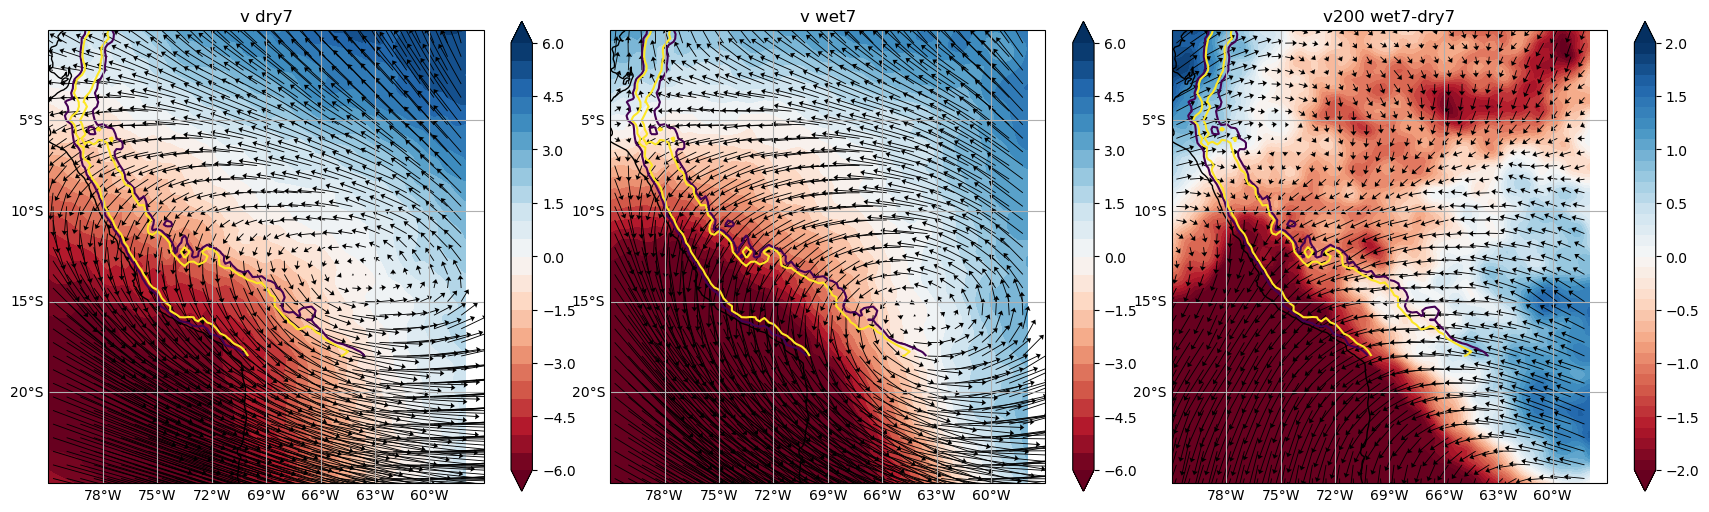

In [144]:
f = plt.figure(figsize=(17,5), dpi=100)

var = 'v'
ax = f.add_subplot(1,3,1, projection=ccrs.PlateCarree())

uanodry = mapsdryu['u']
vanodry = mapsdry['v'] # multiplied by 10 since vertical component is very small compared to horizontal one
uanowet = mapswetu['u']
vanowet = mapswet['v']
st=3
sarrow = 1
xquiv = mapsdryu.longitude[sarrow::st]
yquiv = mapsdryu.latitude[sarrow::st]

uud = (uanodry)[sarrow::st, sarrow::st]  
vvd = (vanodry)[sarrow::st, sarrow::st]

uuw = (uanowet)[sarrow::st, sarrow::st]  
vvw = (vanowet)[sarrow::st, sarrow::st]

ax.coastlines()
        # Gridlines
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False

    
plt.contourf(mapsdry.longitude, mapsdry.latitude, mapsdry[var], levels=np.arange(-6,6.1,0.5), cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
ax.set_xlim(-81,-57)
ax.set_ylim(-25,0)
plt.title(var+' dry7')

ax = f.add_subplot(1,3,2, projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(mapswet.longitude, mapsdry.latitude, mapswet[var], levels=np.arange(-6,6.1,0.5), cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
plt.quiver(xquiv, yquiv, uuw, vvw, scale=55, width=0.002, headwidth=7)
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
ax.set_xlim(-81,-57)
ax.set_ylim(-25,0)
plt.title(var+' wet7')

ax = f.add_subplot(1,3,3, projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(mapswet.longitude, mapsdry.latitude, (mapswet[var]-mapsdry[var]), levels=np.arange(-2,2.1,0.1),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
plt.quiver(xquiv, yquiv, uuw-uud, vvw-vvd, scale=55, width=0.002, headwidth=7)
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
ax.set_xlim(-81,-57)
ax.set_ylim(-25,0)
plt.title(var+'200 wet7-dry7')

plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/drywet/'+var+'250_drywet_3day_'+pregion+'_day0.jpg')

In [73]:
mcs = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY_onBIGERA/*.nc',combine='nested', concat_dim='time')

In [35]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

In [74]:
tir = mcs['tir'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
#tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()

In [37]:
drydates-pd.Timedelta('1days')

DatetimeIndex(['1985-02-05', '1985-12-11', '1986-11-07', '1987-12-05',
               '1988-12-10', '1988-12-19', '1989-01-17', '1989-01-27',
               '1988-11-22', '1989-10-27',
               ...
               '2016-02-02', '2016-03-03', '2016-12-14', '2017-02-12',
               '2017-10-18', '2017-12-01', '2018-01-02', '2018-10-15',
               '2018-12-02', '2018-12-08'],
              dtype='datetime64[ns]', length=139, freq=None)

In [86]:
drytir = np.intersect1d(tir.time.values, drydates) #-pd.Timedelta('1days')

In [87]:
wettir = np.intersect1d(tir.time.values, wetdates)

In [94]:
tirdry = tir.where(tir<-3000).sel(time=drytir).count('time')/len(drytir)*100

In [95]:
tirwet = tir.where(tir<-3000).sel(time=wettir).count('time')/len(wettir)*100

In [96]:
tirdry

<xarray.DataArray 'tir' (latitude: 101, longitude: 93)>
array([[ 0.        ,  0.        ,  0.        , ..., 30.43478261,
        32.60869565, 31.88405797],
       [ 0.        ,  0.        ,  0.        , ..., 28.26086957,
        28.26086957, 31.15942029],
       [ 0.        ,  0.        ,  0.        , ..., 28.98550725,
        31.15942029, 30.43478261],
       ...,
       [ 8.69565217,  7.97101449, 10.86956522, ..., 44.20289855,
        44.92753623, 42.02898551],
       [ 6.52173913,  9.42028986,  8.69565217, ..., 40.57971014,
        36.23188406, 36.95652174],
       [ 4.34782609,  5.79710145,  6.52173913, ..., 33.33333333,
        30.43478261, 27.53623188]])
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0

In [97]:
len(drytir)

138

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


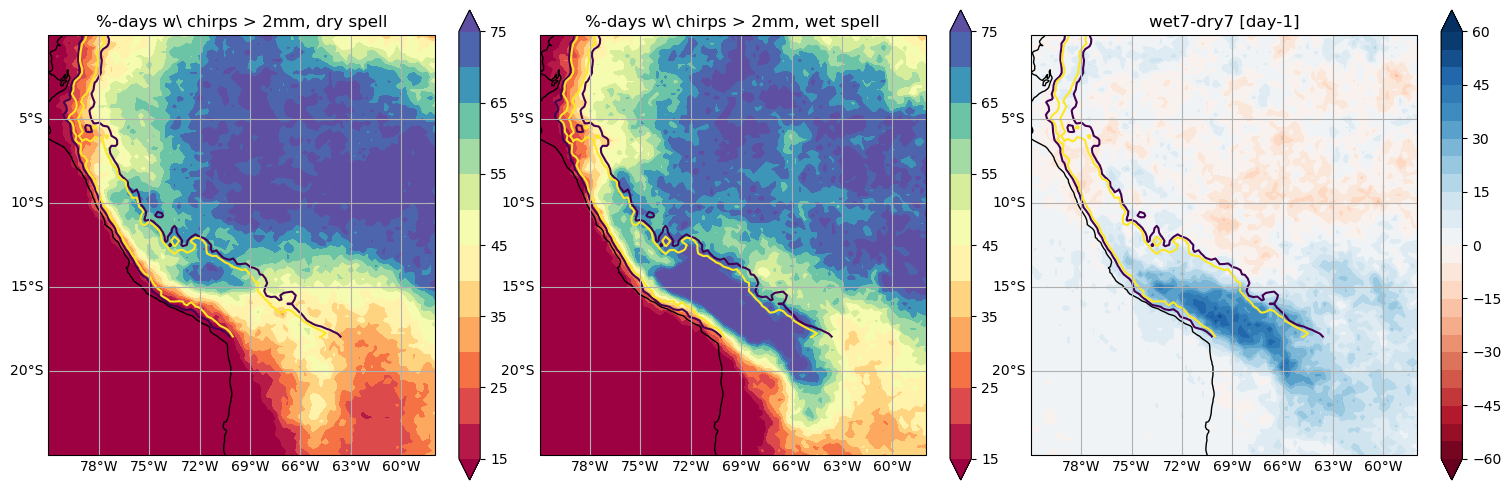

In [98]:
f = plt.figure(figsize=(15,5), dpi=100)


ax = f.add_subplot(1,3,1, projection=ccrs.PlateCarree())
  

ax.coastlines()
        # Gridlines
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False

    
plt.contourf(tirdry.longitude, tirdry.latitude, tirdry, levels=np.arange(15,76,5), cmap='Spectral', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
ax.set_xlim(-81,-58)
ax.set_ylim(-25,0)
plt.title('%-days w\ chirps > 2mm, dry spell')

ax = f.add_subplot(1,3,2, projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(tirwet.longitude, tirwet.latitude, tirwet, levels=np.arange(15,76,5), cmap='Spectral', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
ax.set_xlim(-81,-58)
ax.set_ylim(-25,0)
plt.title('%-days w\ chirps > 2mm, wet spell')

ax = f.add_subplot(1,3,3, projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(tirwet.longitude, tirwet.latitude, (tirwet-tirdry), levels=np.arange(-60,61,5), cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
ax.set_xlim(-81,-58)
ax.set_ylim(-25,0)
plt.title('wet7-dry7 [day-1]')

plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/drywet/gridsat_3days_day0_'+pregion+'.jpg')